In [1]:
import pandas as pd

In [2]:
from libing.main import longitude_matrix

In [3]:
sdf = pd.read_feather('shopping_prepped.feather')

In [ ]:
z, y = longitude_matrix(sdf, 'Customer Id', 
                     ["AMP", "AUR", "BCN", "DASH", "DOGE", "DRC", "EOS", "ETH", "GRC", "IOTA", "KOI", "SRN", "STC", "UBQ", "ZEC", "Rate"],
                     ['Customer Id', 'Effective Date'])

In [5]:
import numpy as np

In [ ]:
noise_factor = 0.3

In [ ]:
noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)

In [8]:
from keras.datasets import mnist

Using TensorFlow backend.


In [9]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

11493376/11490434 [==============================] - 3s 0us/step


In [14]:
import matplotlib.pyplot as plt
import random

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if __name__ == '__main__':
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  app.launch_new_instance()


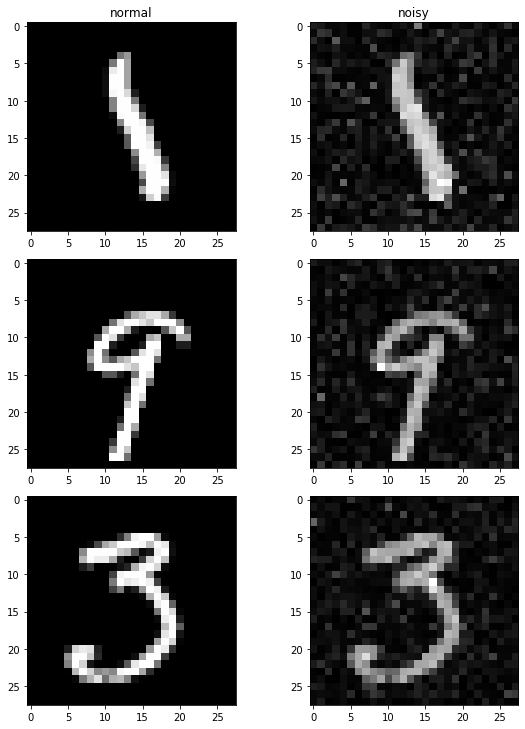

In [33]:
plt.figure(figsize=(8, 10))
plt.subplot(3,2,1).set_title('normal')
plt.subplot(3,2,2).set_title('noisy')
plt.tight_layout()
n = 6

for i in range(1,n+1,2):
    # 2 columns with good on left side, noisy on right side
    ax = plt.subplot(3, 2, i)

    rand_img = random.choice(x_train)
    random_factor = 0.8 * np.random.exponential(scale=30., size=rand_img.shape)
    # plot normal images
    plt.imshow(rand_img, cmap=plt.cm.gray)
    # plot noisy images
    ax = plt.subplot(3,2,i+1)

    plt.imshow(rand_img + random_factor, cmap=plt.cm.gray)
    
plt.show()

In [34]:
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, ZeroPadding2D
from keras.models import Model
from keras.callbacks import TensorBoard
from keras.datasets import mnist
import numpy as np

#(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  # adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))  # adapt this if using `channels_first` image data format

noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)


def train_model():
    input_img = Input(shape=(28, 28, 1))  # adapt this if using `channels_first` image data format
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    encoded = MaxPooling2D((2, 2), padding='same', name='encoder')(x)

    # at this point the representation is (4, 4, 8) i.e. 128-dimensional

    x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(16, (3, 3), activation='relu')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

    autoencoder = Model(input_img, decoded)
    autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

    autoencoder.fit(x_train_noisy, x_train,
                    epochs=20,
                    batch_size=128,
                    shuffle=True,
                    validation_data=(x_test_noisy, x_test),
                    callbacks=[TensorBoard(log_dir='/tmp/tb', histogram_freq=0, write_graph=False)])

    autoencoder.save('autoencoder.h5')

train_model()

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 47s 787us/step - loss: 0.2388 - val_loss: 0.1921
Epoch 2/20
60000/60000 [==============================] - 47s 791us/step - loss: 0.1836 - val_loss: 0.1720
Epoch 3/20
60000/60000 [==============================] - 51s 851us/step - loss: 0.1694 - val_loss: 0.1623
Epoch 4/20
60000/60000 [==============================] - 49s 818us/step - loss: 0.1614 - val_loss: 0.1595
Epoch 5/20
60000/60000 [==============================] - 51s 853us/step - loss: 0.1543 - val_loss: 0.1488
Epoch 6/20
60000/60000 [==============================] - 50s 832us/step - loss: 0.1489 - val_loss: 0.1443
Epoch 7/20
60000/60000 [==============================] - 46s 773us/step - loss: 0.1455 - val_loss: 0.1407
Epoch 8/20
60000/60000 [==============================] - 49s 815us/step - loss: 0.1426 - val_loss: 0.1400
Epoch 9/20
60000/60000 [==============================] - 49s 813us/step - loss: 0.1404 - val_

In [42]:
import numpy as np
from keras.models import Model
from keras.datasets import mnist
#import cv2
from keras.models import load_model
from sklearn.metrics import label_ranking_average_precision_score
import time

print('Loading mnist dataset')
t0 = time.time()
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  # adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))  # adapt this if using `channels_first` image data format

noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)
t1 = time.time()
print('mnist dataset loaded in: ', t1-t0)

print('Loading model :')
t0 = time.time()
# Load previously trained autoencoder
autoencoder = load_model('autoencoder.h5')
t1 = time.time()
print('Model loaded in: ', t1-t0)

Loading mnist dataset
mnist dataset loaded in:  21.237133741378784
Loading model :
Model loaded in:  1.2562365531921387


In [51]:

def plot_denoised_images():
    denoised_images = autoencoder.predict(x_test_noisy.reshape(x_test_noisy.shape[0], x_test_noisy.shape[1], x_test_noisy.shape[2], 1))
    test_img = x_test_noisy[0]*255

    ax = plt.subplot(3, 2, 1)
    plt.imshow(np.squeeze(test_img), cmap=plt.cm.gray)
    output = denoised_images[0]*255
    ax = plt.subplot(3, 2, 2)
    plt.imshow( np.squeeze(output), cmap=plt.cm.gray)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


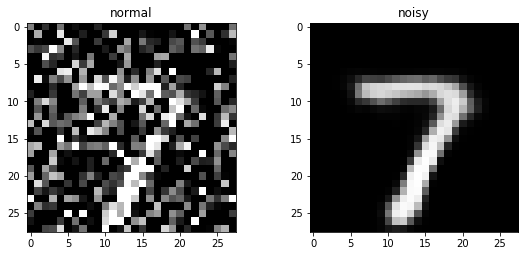

In [52]:
plt.figure(figsize=(8, 10))
plt.subplot(3,2,1).set_title('normal')
plt.subplot(3,2,2).set_title('noisy')
plt.tight_layout()

plot_denoised_images()